# Pipeline Logic Overview

This pipeline processes topic labels from CSV files, performs hierarchical clustering on their embeddings, and generates higher-level topic labels using LLM. It is designed to be modular and trackable with progress bars.

## 1. **Initialization**
- **Initialize Client**: Sets up the Together AI client for generating topic labels.
- **Initialize Model**: Loads the SentenceTransformer model for generating embeddings.

## 2. **Data Loading**
- **Load Datasets**: Reads the first 20 rows from each CSV file and merges them into a single DataFrame.

## 3. **Embedding Calculation**
- **Compute Embeddings**: Transforms the topic labels into vector embeddings using the SentenceTransformer model.

## 4. **Hierarchical Clustering**
- **Perform Clustering**: Applies hierarchical clustering (Ward’s method) to the embeddings and plots a dendrogram.
- **Assign Cluster Labels**: Cuts the dendrogram at a specified height to assign cluster labels to the topics.

## 5. **Subtopic Grouping**
- **Group by Cluster**: Aggregates the topics, embeddings, keywords, and representative documents for each cluster.

## 6. **Higher-Level Topic Label Generation**
- **Generate Labels**: Uses the Together AI service to generate concise, higher-level topic labels for each cluster.
- **Identify Representative Document**: Finds the most representative document for each cluster based on cosine similarity.

## 7. **Result Saving**
- **Save to CSV**: Saves the final DataFrame, containing the higher-level topic labels and representative documents, to a CSV file.

## 8. **Progress Tracking**
- **TQDM Integration**: Progress bars are integrated to monitor the time and success of each step in the pipeline.


Loading datasets: 100%|██████████| 2/2 [00:00<00:00, 221.90it/s]
/home/yc656703/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing embeddings: 100%|██████████| 40/40 [00:00<00:00, 357.27it/s]


Performing hierarchical clustering


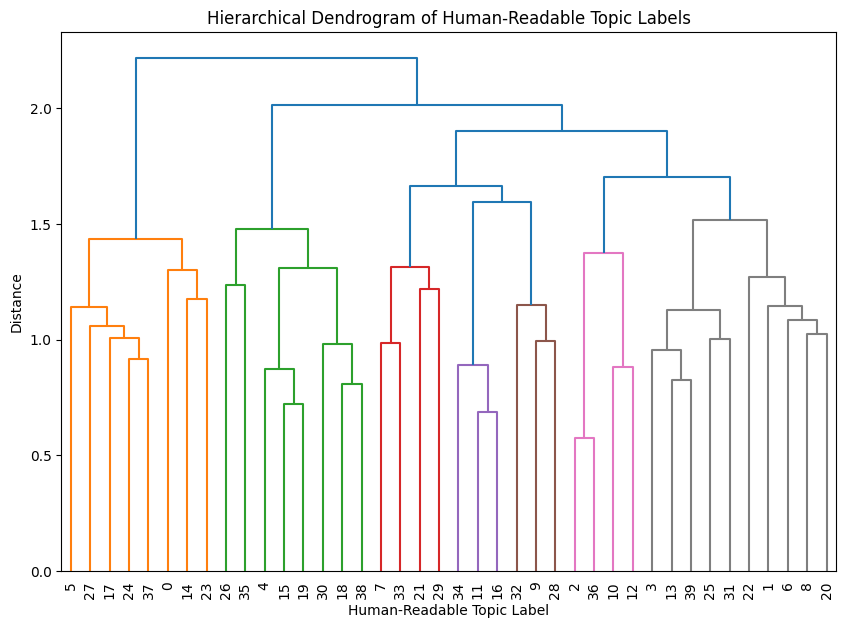

Assigning cluster labels
Grouping subtopics by cluster


Processing clusters: 100%|██████████| 17/17 [00:00<00:00, 5573.61it/s]

Higher-level topic labels with representations saved to higherr_level_topic_labels_with_representatives.csv


In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from together import Together
from tqdm import tqdm

# Initialize the language model client
def initialize_client(api_key: str):
    return Together(api_key=api_key)

# Load and merge datasets, reading only the first 20 rows
def load_and_merge_datasets(filepaths: list) -> pd.DataFrame:
    dataframes = []
    for filepath in tqdm(filepaths, desc="Loading datasets"):
        df = pd.read_csv(filepath, nrows=50)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# Initialize the sentence transformer model
def initialize_model(model_name: str):
    return SentenceTransformer(model_name)

# Generate higher-level topic label using Together AI
def generate_topic_label_together(client, subtopics: str, keywords: str, representative_docs: str) -> str:
    prompt = (
        f"You are an intelligent assistant skilled in generating labels for topics. "
        f"Given the following details about a set of subtopics:\n"
        f"Subtopics: {subtopics}\n"
        f"Representative Documents: {representative_docs}\n"
        f"Keywords: {keywords}\n"
        f"Please generate a concise, human-readable, higher-level topic label that groups these subtopics into a broader category. "
        f"Focus on capturing the main idea without delving into overly specific details. "
        f"Return only the higher-level topic label nothing else!"
    )

    stream = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        messages=[{"role": "user", "content": prompt}],
        stream=True,
        temperature=0.1,
    )

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ""

    return response.strip()

# Compute embeddings for each topic
def compute_embeddings(df: pd.DataFrame, model) -> pd.DataFrame:
    tqdm.pandas(desc="Computing embeddings")
    df['Embeddings'] = df['Human_Readable_Topic'].progress_apply(lambda x: model.encode(x))
    return df

# Perform hierarchical clustering and plot dendrogram
def perform_clustering(embeddings: np.ndarray):
    print("Performing hierarchical clustering")
    Z = linkage(embeddings, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(Z, leaf_rotation=90, leaf_font_size=10)
    plt.title("Hierarchical Dendrogram of Human-Readable Topic Labels")
    plt.xlabel("Human-Readable Topic Label")
    plt.ylabel("Distance")
    plt.show()
    return Z

# Assign cluster labels based on dendrogram cut height
def assign_cluster_labels(Z, df: pd.DataFrame, cut_height: float) -> pd.DataFrame:
    print("Assigning cluster labels")
    df['Cluster_Label'] = fcluster(Z, cut_height, criterion='distance')
    return df

# Group data by cluster label
def group_subtopics_by_cluster(df: pd.DataFrame) -> pd.DataFrame:
    print("Grouping subtopics by cluster")
    grouped_df = df.groupby('Cluster_Label').agg({
        'Human_Readable_Topic': lambda x: ' , '.join(x),
        'Embeddings': lambda x: np.vstack(x),
        'Representation': lambda x: ' , '.join(x),
        'Representative_Docs': lambda x: ' , '.join(x)
    }).reset_index()
    return grouped_df

# Find representative document for each cluster
def find_representative_document(embeddings, subtopics: list) -> str:
    centroid = np.mean(embeddings, axis=0)
    similarities = cosine_similarity([centroid], embeddings)
    most_representative_idx = np.argmax(similarities)
    return subtopics[most_representative_idx]

# Process each cluster to generate higher-level topic labels and find representative documents
def process_clusters(grouped_subtopics: pd.DataFrame, client) -> pd.DataFrame:
    tqdm.pandas(desc="Processing clusters")
    grouped_subtopics['Higher_Topic_Label'] = grouped_subtopics.progress_apply(
        lambda row: generate_topic_label_together(
            client,
            row['Human_Readable_Topic'], 
            row['Representation'], 
            row['Representative_Docs']
        ), axis=1
    )

    grouped_subtopics['Representative_Document'] = grouped_subtopics.progress_apply(
        lambda row: find_representative_document(
            row['Embeddings'], 
            row['Human_Readable_Topic'].split(' , ')
        ), axis=1
    )
    return grouped_subtopics

# Save the results to a CSV file
def save_results(df: pd.DataFrame, output_file: str):
    df.drop(columns=['Embeddings']).to_csv(output_file, index=False)
    print(f"Higher-level topic labels with representations saved to {output_file}")

# Main function to execute the workflow
def main():
    # Configuration
    api_key = ''
    filepaths = ['First_Step_Topic_Clusters_with_human_readable_label.csv', 
                 'Second_Step_Topic_Clusters_with_human_readable_label.csv']
    model_name = 'all-MiniLM-L6-v2'
    cut_height = 1.2
    output_file = 'higherr_level_topic_labels_with_representatives.csv'

    # Workflow
    client = initialize_client(api_key)
    df = load_and_merge_datasets(filepaths)
    model = initialize_model(model_name)
    df = compute_embeddings(df, model)
    Z = perform_clustering(np.vstack(df['Embeddings']))
    df = assign_cluster_labels(Z, df, cut_height)
    grouped_subtopics = group_subtopics_by_cluster(df)
    grouped_subtopics = process_clusters(grouped_subtopics, client)
    save_results(grouped_subtopics, output_file)

# Run the main function
if __name__ == "__main__":
    main()


Loading datasets: 100%|██████████| 2/2 [00:00<00:00, 73.93it/s]
/home/yc656703/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing embeddings: 100%|██████████| 20/20 [00:00<00:00, 398.21it/s]


Performing hierarchical clustering


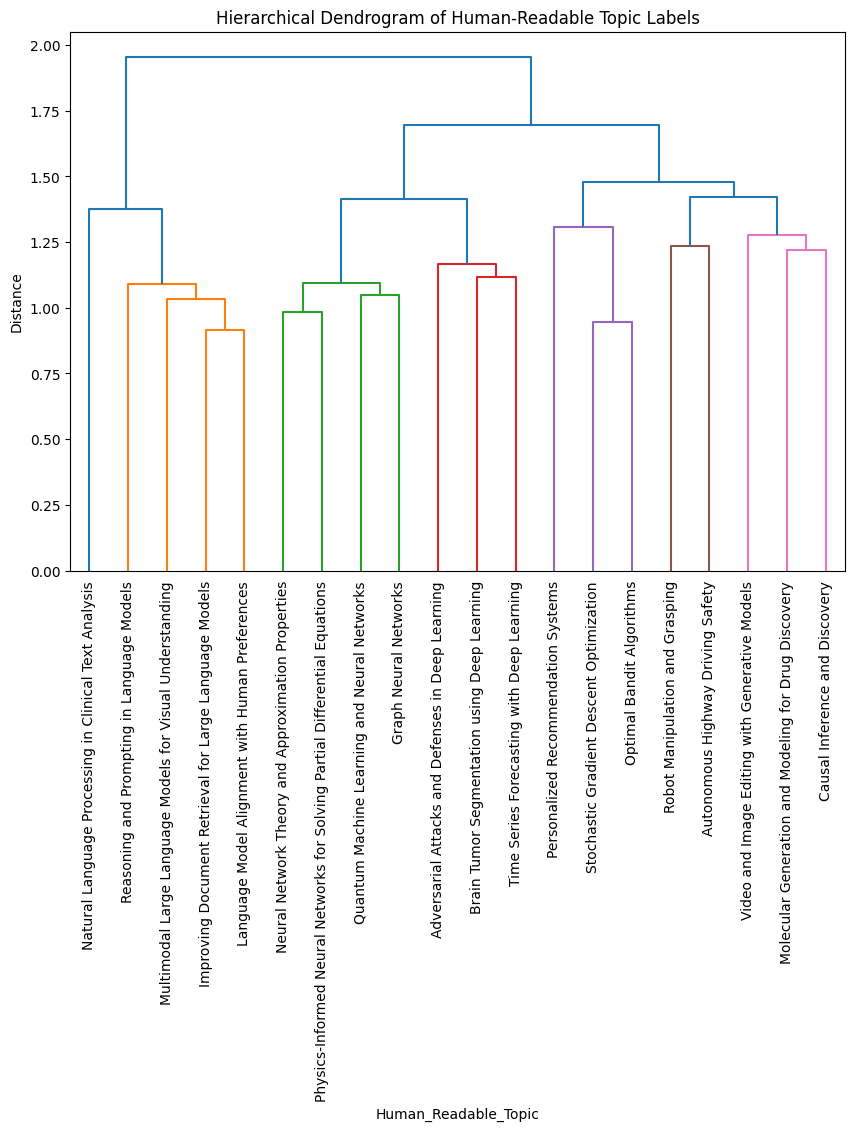

Assigning cluster labels
Grouping subtopics by cluster


Processing clusters: 100%|██████████| 11/11 [00:00<00:00, 4431.60it/s]

Higher-level topic labels with representations saved to Hierchical_Topics_Second_Level-Topics.csv


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from together import Together
from tqdm import tqdm

# Initialize the language model client
def initialize_client(api_key: str):
    return Together(api_key=api_key)

def load_and_merge_datasets(filepaths: list) -> pd.DataFrame:
    dataframes = []
    for filepath in tqdm(filepaths, desc="Loading datasets"):
        df = pd.read_csv(filepath)
        if 'Topic' in df.columns:
            df = df[df['Topic'] != -1] 
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# Initialize the sentence transformer model
def initialize_model(model_name: str):
    return SentenceTransformer(model_name)

# Generate higher-level topic label using Together AI
def generate_topic_label_together(client, subtopics: str, keywords: str, representative_docs: str) -> str:
    prompt = (
        f"You are an intelligent assistant skilled in generating labels for topics derived from paper abstracts. "
        f"Given the following details about a set of subtopics:\n"
        f"Subtopics: {subtopics}\n"
        f"Representative Documents: {representative_docs}\n"
        f"Keywords: {keywords}\n"
        f"Please generate a concise, human-readable, higher-level topic label that groups these subtopics into a broader category. "
        f"Focus on capturing the main idea without delving into overly specific details. "
        f"Return only the higher-level topic label nothing else!"
    )

    stream = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        messages=[{"role": "user", "content": prompt}],
        stream=True,
        temperature=0.1,
    )

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ""

    return response.strip()

# Compute embeddings for each topic
def compute_embeddings(df: pd.DataFrame, model) -> pd.DataFrame:
    tqdm.pandas(desc="Computing embeddings")
    df['Embeddings'] = df['Human_Readable_Topic'].progress_apply(lambda x: model.encode(x))
    return df


# Perform hierarchical clustering and plot dendrogram
def perform_clustering(embeddings: np.ndarray, labels: list):
    print("Performing hierarchical clustering")
    Z = linkage(embeddings, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=10)
    plt.title("Hierarchical Dendrogram of Human-Readable Topic Labels")
    plt.xlabel("Human_Readable_Topic")
    plt.ylabel("Distance")
    plt.show()
    return Z


# Assign cluster labels based on dendrogram cut height
def assign_cluster_labels(Z, df: pd.DataFrame, cut_height: float) -> pd.DataFrame:
    print("Assigning cluster labels")
    df['Cluster_Label'] = fcluster(Z, cut_height, criterion='distance')
    return df

# Group data by cluster label
def group_subtopics_by_cluster(df: pd.DataFrame) -> pd.DataFrame:
    print("Grouping subtopics by cluster")
    grouped_df = df.groupby('Cluster_Label').agg({
        'Human_Readable_Topic': lambda x: ' , '.join(x),
        'Embeddings': lambda x: np.vstack(x),
        'Representation': lambda x: ' , '.join(x),
        'Representative_Docs': lambda x: ' , '.join(x)
    }).reset_index()
    return grouped_df

# Find representative document for each cluster
def find_representative_document(embeddings, subtopics: list) -> str:
    centroid = np.mean(embeddings, axis=0)
    similarities = cosine_similarity([centroid], embeddings)
    most_representative_idx = np.argmax(similarities)
    return subtopics[most_representative_idx]

# Process each cluster to generate higher-level topic labels and find representative documents
def process_clusters(grouped_subtopics: pd.DataFrame, client) -> pd.DataFrame:
    tqdm.pandas(desc="Processing clusters")
    grouped_subtopics['Second_Level_Topic_Label'] = grouped_subtopics.progress_apply(
        lambda row: generate_topic_label_together(
            client,
            row['Human_Readable_Topic'], 
            row['Representation'], 
            row['Representative_Docs']
        ), axis=1
    )

    grouped_subtopics['Representative_Document'] = grouped_subtopics.progress_apply(
        lambda row: find_representative_document(
            row['Embeddings'], 
            row['Human_Readable_Topic'].split(' , ')
        ), axis=1
    )
    return grouped_subtopics

# Save the results to a CSV file
def save_results(df: pd.DataFrame, output_file: str):
    df.drop(columns=['Embeddings']).to_csv(output_file, index=False)
    print(f"Higher-level topic labels with representations saved to {output_file}")

# Main function to execute the workflow
def main():
    # Configuration
    api_key = ''
    filepaths = ['First_Step_Topic_Clusters_with_human_readable_label.csv', 
                 'Second_Step_Topic_Clusters_with_human_readable_label.csv']
    model_name = 'all-MiniLM-L6-v2'
    cut_height = 1.2
    output_file = 'Hierchical_Topics_Second_Level-Topics.csv'
    
    
    # # Workflow
    client = initialize_client(api_key)
    df = load_and_merge_datasets(filepaths)
    model = initialize_model(model_name)
    df = df[:20]
    df = compute_embeddings(df, model)
    Z = perform_clustering(np.vstack(df['Embeddings']), df['Human_Readable_Topic'].tolist())
    df = assign_cluster_labels(Z, df, cut_height)
    grouped_subtopics = group_subtopics_by_cluster(df)
    grouped_subtopics = process_clusters(grouped_subtopics, client)
    save_results(grouped_subtopics, output_file)

# Run the main function
if __name__ == "__main__":
    main()
